In [10]:
YEAR='2022'
RES_PATH='C:\\Users\\14106\\GAT\\result\\'
DATA_PATH='C:\\Users\\14106\\GAT\\preprocessed'+YEAR+'\\'
CODE_PATH="C:\\Users\\14106\\GAT\\"
RAW_PATH="C:\\Users\\14106\\GAT\\100school\\"
ORIG_UNIV=['columbia',"notredame","uofm","UCSD",'berkeley',"Harvard","ucla", 'dartmouth']
CUTOFF_GAT=0.428274
CUTOFF_BERT=0.692322
BETA=[-2.97772323,2.4231413,3.24225897]
USE_OVERALL=True

#C:\Backup of covid project\2cls_CScombined_negVSnonneg
import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import rando
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import nltk
import contractions
import inflect
import heapq
import pickle
import warnings
import tqdm
#from keras.preprocessing.sequence import pad_sequences
import random
from sklearn.utils import shuffle
from scipy.special import softmax
from math import exp
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [11]:
def get_school_name():
    files = os.listdir(DATA_PATH)
    #print(files)
    w=[f for f in files if f[0:15]=='feature_sampled']
    files = [f[16:-4] for f in files if f[0:15]=='feature_sampled']
    
    return files

def get_subreddits():
    os.chdir(RAW_PATH)
    dat = pd.read_csv('colleges-CCIHE-final.csv')
    schools = []
    for i in range(len(dat.name)):
        schools.append(dat.loc[i, 'subreddit'])
    return schools

def ensemble(s:str, df):
    df.rename(columns={'emo_pred_pos': 'bert_pos',
                       'emo_pred_neu': 'bert_neu', 
                       'emo_pred_neg': 'bert_neg'}, inplace=True)
    df['bert_nneg']=1-df['bert_neg']
    df.drop(['bert_pos', 'bert_neu'], inplace=True, axis=1)
    get_gat_result(s, df)
    scaling_prob(s, df)
    use_year=False
    if YEAR=='2019' or YEAR=='2020':
        use_year=True
    beta=get_coef(s, use_year)
    if USE_OVERALL:
        beta=BETA
    combine_probs(s, df, beta)
    df2csv(s, df)
    
def get_gat_result(s:str, df):
    os.chdir(RES_PATH)
    name=s+'_'+YEAR+'.p'
    predicted=pickle.load(open(name,'rb'))
    m=softmax(predicted,axis=1)
    df['gat_neg']=m[:,0]
    df['gat_nneg']=m[:,1]
    
            
def scaling_prob(s:str, df):
    flag=(df['gat_nneg']>=CUTOFF_GAT).apply(int)
    new_pos=flag*(0.5*(df['gat_nneg']-CUTOFF_GAT)/(1-CUTOFF_GAT)+0.5)+(1-flag)*(0.5*df['gat_nneg']/CUTOFF_GAT)
    df['gat_nneg_norm']=new_pos
    df['gat_neg_norm']=1-new_pos

    flag=(df['bert_nneg']>=CUTOFF_BERT).apply(int)
    new_pos=flag*(0.5*(df['bert_nneg']-CUTOFF_BERT)/(1-CUTOFF_BERT)+0.5)+(1-flag)*(0.5*df['bert_nneg']/CUTOFF_BERT)
    df['bert_nneg_norm']=new_pos
    df['bert_neg_norm']=1-new_pos

def combine_probs(s:str, df, beta):
    log_pos_odds=beta[0]+beta[1]*df['gat_nneg_norm']+beta[2]*df['bert_nneg_norm']
    odds=(log_pos_odds).apply(exp)
    p_pos=odds/(1+odds)
    df['esm_nneg']=p_pos
    df['esm_neg']=1-p_pos

def df2csv(s:str, df):
    os.chdir(RES_PATH)
    name=s+'_'+YEAR+'_prob.csv'
    df.to_csv(name, header=True,index=False,encoding="utf-8-sig")

def in_list(s:str,ss:list):
    return s in ss

def get_coef(sc:str, use_year: bool):#the school that you wanna get coeff for
    os.chdir(CODE_PATH)
    with open('cluster.pkl', 'rb') as f:
         dic= pickle.load(f)
    schools=dic[sc]
    #if sc in ORIG_UNIV:
    #    schools=[sc]
    df=pd.read_csv('past - dm1920copied.csv')
    if use_year:
    #SPECIFYING YEAR
        trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_han_pos_norm'],dtype=float), 
                    np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_bert_pos_norm'],dtype=float))))
        testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_han_pos_norm'],dtype=float), 
                    np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_bert_pos_norm'],dtype=float))))
        trainy=np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['truth_rand'],dtype=float)
        testy =np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['truth_rand'],dtype=float)

    #WITHOUT SPECIFYING YEAR
    if not use_year:
        trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools))]['pred_han_pos_norm'],dtype=float), 
                    np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools))]['pred_bert_pos_norm'],dtype=float))))
        testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools))]['pred_han_pos_norm'],dtype=float), 
                    np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools))]['pred_bert_pos_norm'],dtype=float))))
        trainy=np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools))]['truth_rand'],dtype=float)
        testy =np.array(df.loc[(df.vali==1) & (df['school'].apply(in_list,ss=schools))]['truth_rand'],dtype=float)

    # fit a model
    model = LogisticRegression(solver='lbfgs')#,fit_intercept=False)
    model.fit(trainX, trainy)
    return list(model.intercept_)+list(model.coef_[0,:])

In [12]:
schools=get_subreddits()
for s in tqdm.tqdm(schools[0:]):
    os.chdir(DATA_PATH)
    name=s+'_'+YEAR+'_sampled.csv'
    df=pd.read_csv(name,skip_blank_lines=True)
    ensemble(s, df)


100%|█████████████████████████████████████████████████████████████████████| 128/128 [01:17<00:00,  1.66it/s]


In [70]:
for u in ORIG_UNIV:
    print(get_coef(u))
#['columbia',"notredame","uofm","UCSD",'berkeley',"Harvard","ucla", 'dartmouth']

[-1.9844362271511182, 1.9509084539579045, 1.9913152543599664]
[-1.593879627567469, 1.6435917976732082, 1.937362121659135]
[-1.7553337778160232, 1.7228575142882883, 1.7765901749714883]
[-1.909744956264433, 1.9780436817034088, 1.7851076139301751]
[-2.5447198558632946, 1.9789326534499392, 2.127186485607913]
[-1.9018289802418116, 1.7919108288438002, 1.7465997773451514]
[-1.7872817822456977, 1.674825840796598, 1.664431768131302]
[-2.3211420610626425, 1.986623440672888, 1.9097587539196859]


In [ ]:
sc='amherstcollege'
os.chdir(CODE_PATH)
with open('cluster.pkl', 'rb') as f:
     dic= pickle.load(f)
schools=dic[sc]
if sc in ORIG_UNIV:
    schools=[sc]
df=pd.read_csv('past - dm1920copied.csv')
trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0) & (df['school'].apply(in_list,ss=schools)) & (df.year==int(YEAR))]['pred_bert_pos_norm'],dtype=float))))
trainX


In [14]:
s

'dartmouth'

# Analysis

In [68]:
os.chdir(RES_PATH)
schools=get_subreddits()
#schools.remove('colu')
sizes=[]
neg_perc=[]
for s in tqdm.tqdm(schools[0:]):
    os.chdir(RES_PATH)
    name=s+'_'+YEAR+'_prob.csv'
    df=pd.read_csv(name,encoding="utf-8-sig")
    sizes.append(len(df.index))
    neg_perc.append(sum(df['esm_neg']>0.5)/sizes[-1])

100%|█████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.67it/s]


In [11]:
idx=neg_perc.index(max(neg_perc))
schools[idx]

'uofi'

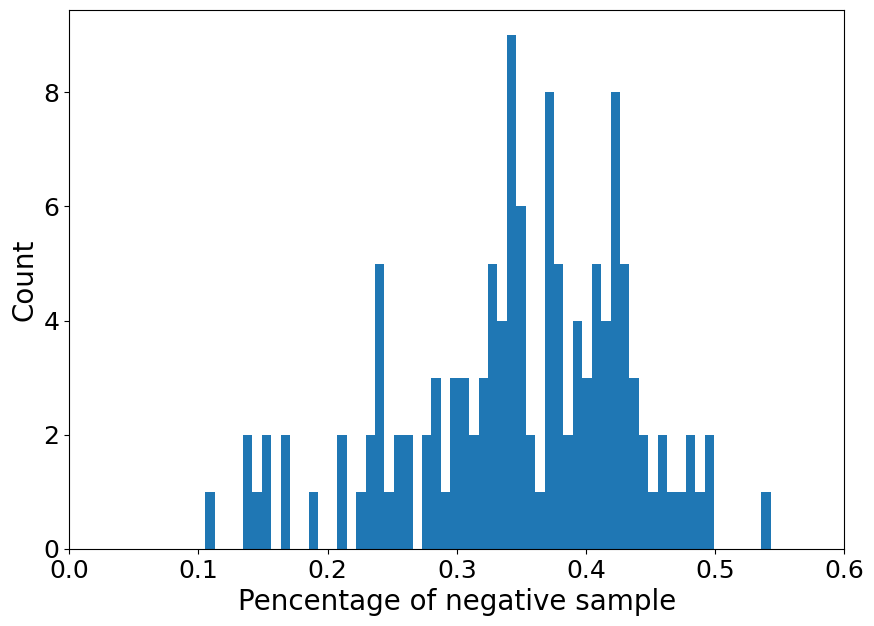

In [52]:
from matplotlib import pyplot as plt

os.chdir(DATA_PATH)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(neg_perc, bins=60)
plt.xlabel("Pencentage of negative sample", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.xlim([0, 0.6])
plt.show()

In [26]:
import pandas as pd
import numpy as np

df_describe = pd.DataFrame(neg_perc)
df_describe.describe()



,0
count,128.000000
mean,0.292524
std,0.081505
min,0.055556
25%,0.235919
50%,0.306473
75%,0.351260
max,0.545580


In [69]:
school8 = ["notredame","uofm","UCSD",'berkeley',"Harvard","ucla", 'dartmouth','columbia']
schools_2019_neg_old=[25.02, 32.94, 37.15, 39.88, 32.32, 36.23, 24.18, 33.51]# this version, table 3 used per school stacking, but glmm used overall stacking parameter
#schools_2019_neg_old=[20.01, 31.44, 36.02, 47.97, 33.43, 37.41, 30.22, 31.72]# this version, used per school stacking for glmm
for i, s in enumerate(school8):
    idx=schools.index(s)
    print(s, neg_perc[idx]*100-schools_2019_neg_old[i])

notredame -0.004167194426852205
uofm 0.004746087511982466
UCSD 3.999542909838283e-05
berkeley 0.00484375937143966
Harvard -0.0006083650190120693
ucla 0.0017982715757085543
dartmouth -0.004175824175824516
columbia 0.00222420989862826


In [64]:
school8 = ["notredame","uofm","UCSD",'berkeley',"Harvard","ucla", 'dartmouth','columbia']
schools_2020_neg_old=[53.23, 46.52, 38.60, 42.32, 32.02, 41.04, 23.16, 36.66]
#schools_2020_neg_old=[55.80, 47.66, 38.41, 45.79, 34.33, 33.57, 29.12, 35.98]
for i, s in enumerate(school8):
    idx=schools.index(s)
    print(s, neg_perc[idx]*100-schools_2020_neg_old[i])

notredame 0.0027044025157181295
uofm 0.0019436790106794888
UCSD 0.0025596679349675355
berkeley -0.003851819281081248
Harvard 0.0002588632526681067
ucla -0.0012055145880083273
dartmouth 0.004763458401303211
columbia 0.0005976223626475985


In [34]:
def get_senti_class(e):
    return e>0.5

schools=get_subreddits()
num8=0
neg8=0
num=0
neg=0
for s in tqdm.tqdm(schools[0:]):
    os.chdir(RES_PATH)
    name=s+'_'+YEAR+'_prob.csv'
    df=pd.read_csv(name,skip_blank_lines=True)
    n_neg=sum(df.esm_neg.apply(get_senti_class))
    n=len(df.esm_neg)
    if n_neg/n>0.5:
        print([s, n_neg/n])
    num+=n
    neg+=n_neg
    if s in ORIG_UNIV:
        #print(s)
        num8+=n
        neg8+=n_neg
print(neg/num)
print(neg8/num8)

  7%|████▉                                                                  | 9/128 [00:01<00:10, 11.13it/s]

['byu', 0.5007596475235491]


 53%|█████████████████████████████████████▏                                | 68/128 [00:08<00:13,  4.39it/s]

['Tulane', 0.5046728971962616]


 59%|█████████████████████████████████████████                             | 75/128 [00:09<00:08,  6.18it/s]

['berkeley', 0.5005333333333334]


 68%|███████████████████████████████████████████████▌                      | 87/128 [00:11<00:05,  6.99it/s]

['uofi', 0.6020671834625323]


 69%|████████████████████████████████████████████████▏                     | 88/128 [00:12<00:08,  4.84it/s]

['umaine', 0.5263157894736842]


 86%|███████████████████████████████████████████████████████████▎         | 110/128 [00:14<00:01, 12.77it/s]

['sooners', 0.5469971401334605]


100%|█████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.69it/s]

0.36367168721702453
0.41092257522376324


In [28]:
num8

129713

In [ ]:
#get GLMM ready for BERT alone and RoBERTa alone
os.chdir(path_data)

#Time period: Aug to Nov 2019 (baseline) and  Aug to Nov. 2020;
#A in person learning 1; others (online, hybrid) 0
#B small city 1, large city 0
#C private 1, public 0
#   A  B  C 
#1  1  1  1  
#2  1  1  0 
#3  1  0  1   
#4  0  1  1
#5  1  0  0   
#6  0  1  0 
#7  0  0  1   
#8  0  0  0  

#1 Notre Dame (in-person learning 1, small city 1, private 1)
#2  Michigan   ( in-person learning  1,  small city 1, public 0)
#3. Columbia   ( in-person  1, large city 0, private 1) 
#4. Dartmouth  (online 0,  small city 1, private 1)
#5  UCSD (in-person learning 1,  large city 0 , public 0)  
#6  xxx   (0 online  small city 1, public 0)  
#7  Harvard    (online 0,  large city 0, private 1)
#8  UCLA (online 0,  large city 0, public 0)

#Positive: 1, negative:0
#2020:1, 2019:0
#Positive: 1, negative:0

for d in range(len(df_all["schoolyear"])):
    if (d/1000-int(d/1000))==0:
        print(d)
    y=df_all['year'][d]
    s=df_all['school'][d]
    #sentence=data["body"][d]
    #emb=np.array(use(sentence))[0]
    line=[df_all["pred_HAN"][d]]
    line.append(2)#0 si 2019, 1 is 2020, 2 is 2021
    line.append(1)#all is in-person learning
    '''
    if categ[s][0]==1:
        line.append(1)
    elif categ[s][0]==0:
        if y=='2020':
            line.append(0)
        elif y=='2019':
            line.append(1)
    '''
    line.append(categ[s][1])#city
    line.append(categ[s][2])#funding type
    line.append(categ[s][3])#schools
    name='GLMM_esm_han_2021.csv'
    os.chdir(path_result)
    e=open(name, 'a',newline='')
    with e:
        writer = csv.writer(e, delimiter=',')
        writer.writerow(line)

        
for d in range(len(df_all["schoolyear"])):
    if (d/1000-int(d/1000))==0:
        print(d)
    y=df_all['year'][d]
    s=df_all['school'][d]
    #sentence=data["body"][d]
    #emb=np.array(use(sentence))[0]
    line=[df_all["pred_BERT"][d]]
    line.append(2)#0 si 2019, 1 is 2020, 2 is 2021
    line.append(1)#all is in-person learning
    '''
    if categ[s][0]==1:
        line.append(1)
    elif categ[s][0]==0:
        if y=='2020':
            line.append(0)
        elif y=='2019':
            line.append(1)
    '''
    line.append(categ[s][1])#city
    line.append(categ[s][2])#funding type
    line.append(categ[s][3])#schools
    #line=line+emb.tolist()
    name='GLMM_esm_bert_2021.csv'
    os.chdir(path_result)
    e=open(name, 'a',newline='')
    with e:
        writer = csv.writer(e, delimiter=',')
        writer.writerow(line)
#df_all

In [13]:
#format it table for plosone table4
#change the sequence you copy paste

years=['2019','2020']
methods=['GAT','bert','ens']
schoolyears2019=["ucla2019","UCSD2019","berkeley2019","uofm2019","Harvard2019","columbia2019","dartmouth2019","notredame2019",'overall2019']
schoolyears2020=["ucla2020","UCSD2020","berkeley2020","uofm2020","Harvard2020","columbia2020","dartmouth2020","notredame2020",'overall2020']
schools=["ucla","UCSD","berkeley","uofm","Harvard","columbia","dartmouth","notredame"]
schoolnames=["UCLA","UCSD","UCB","UMich","Harvard","Columbia","Dartmouth","ND"]
neg2019=[]
pos2019=[]
total2019=[]

neg2020=[]
pos2020=[]
total2020=[]
for s in schools:
    for y in years:
        if y=='2019':
            line='\\multirow{2}{5em}{'+schoolnames[schools.index(s)]+'}'+' & 2019 & '
            neg=len(df_all.loc[(df_all.pred_esm==float(0)) & (df_all.school==s) & (df_all.year==(y))]['year'])
            pos=len(df_all.loc[(df_all.pred_esm==float(1)) & (df_all.school==s) & (df_all.year==(y))]['year'])
            total=neg+pos
            neg2019.append(neg)
            pos2019.append(pos)
            total2019.append(total)
        elif y=='2020':
            line=' & 2020 & '
            neg=len(df_all.loc[(df_all.pred_esm==float(0)) & (df_all.school==s) & (df_all.year==(y))]['year'])
            pos=len(df_all.loc[(df_all.pred_esm==float(1)) & (df_all.school==s) & (df_all.year==(y))]['year'])
            total=neg+pos
            neg2020.append(neg)
            pos2020.append(pos)
            total2020.append(total)
        perc='{:.2f}'.format(round(neg/total*100, 2))
        line=line+str(neg)+' & '+str(pos)+' & '+str(total)+' & '+perc+"\\\\"
        print(line)
    print('\\hline')
line='\\multirow{2}{5em}{total}'+' & 2019 & '
neg=sum(neg2019)
pos=sum(pos2019)
total=sum(total2019)
perc='{:.2f}'.format(round(neg/total*100, 2))
line=line+str(neg)+' & '+str(pos)+' & '+str(total)+' & '+perc+"\\\\"
print(line)

line=' & 2020 & '
neg=sum(neg2020)
pos=sum(pos2020)
total=sum(total2020)
perc='{:.2f}'.format(round(neg/total*100, 2))
line=line+str(neg)+' & '+str(pos)+' & '+str(total)+' & '+perc+"\\\\"
print(line)
print('\\hline')

\multirow{2}{5em}{UCLA} & 2019 & 6121 & 10773 & 16894 & 36.23\\
 & 2020 & 7680 & 11034 & 18714 & 41.04\\
\hline
\multirow{2}{5em}{UCSD} & 2019 & 6502 & 11000 & 17502 & 37.15\\
 & 2020 & 6696 & 10650 & 17346 & 38.60\\
\hline
\multirow{2}{5em}{UCB} & 2019 & 6650 & 10023 & 16673 & 39.88\\
 & 2020 & 7699 & 10495 & 18194 & 42.32\\
\hline
\multirow{2}{5em}{UMich} & 2019 & 4126 & 8398 & 12524 & 32.94\\
 & 2020 & 6922 & 7957 & 14879 & 46.52\\
\hline
\multirow{2}{5em}{Harvard} & 2019 & 935 & 1958 & 2893 & 32.32\\
 & 2020 & 1138 & 2416 & 3554 & 32.02\\
\hline
\multirow{2}{5em}{Columbia} & 2019 & 1686 & 3345 & 5031 & 33.51\\
 & 2020 & 3423 & 5914 & 9337 & 36.66\\
\hline
\multirow{2}{5em}{Dartmouth} & 2019 & 308 & 966 & 1274 & 24.18\\
 & 2020 & 284 & 942 & 1226 & 23.16\\
\hline
\multirow{2}{5em}{ND} & 2019 & 395 & 1184 & 1579 & 25.02\\
 & 2020 & 4232 & 3718 & 7950 & 53.23\\
\hline
\multirow{2}{5em}{total} & 2019 & 26723 & 47647 & 74370 & 35.93\\
 & 2020 & 38074 & 53126 & 91200 & 41.75\\
\hline


In [9]:
path_result='C:\\Backup of covid project\\2cls_CScombined_negVSnonneg\\results\\'
path_data="C:\\Backup of covid project\\2cls_CScombined_negVSnonneg\\data\\"
path_code="C:\\Backup of covid project\\2cls_CScombined_negVSnonneg\\"

#path_result='C:\\Backup of covid project\\2cls_wlNeu_woNeu\\results_WOneu\\'
#path_data="C:\\Backup of covid project\\2cls_wlNeu_woNeu\\data\\"
#path_code="C:\\Backup of covid project\\"

import time
import numpy as np
import tensorflow as tf
import os
import random
os.chdir(path_code)
import gat
import imp
imp.reload(gat)
from gat import GAT, HeteGAT, HeteGAT_multi  # or * for that matter

import process
import importlib
importlib.reload(process)
import numpy as np
import scipy.io as sio
import scipy.sparse as sp


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

   
def load_data_dblp(path=path_data):


    import pandas as pd
    import pickle
    import scipy.sparse
    from scipy.sparse import csc_matrix
    from scipy import sparse
    import numpy as np 
    import os 
    import csv 
    import numpy as np
    schools = ["notredame","uofm","columbia","dartmouth","UCSD","berkeley","Harvard","ucla"]
    s=schools[3]#use this index to control which network we are going to run.
    t="comment"
    
    os.chdir(path)
    name="label_emt3_"+s+".csv"
    truelabels=pd.read_csv(name,skip_blank_lines=True,header=None)
    name="feature_"+s+".csv"
    truefeatures=pd.read_csv(name,skip_blank_lines=True,header=None).values
    #name="feature_"+s+t+".npz"
    #truefeatures=scipy.sparse.load_npz(name)
    #truefeatures=truefeatures.toarray()

    N=truefeatures.shape[0]
    name="CCasym_"+s+".npz"
    dat_cc=scipy.sparse.load_npz(name);
    dat_cc.transpose(axes=None, copy=False)
    dat_cc=dat_cc.toarray();
    #name="CCsym_"+s+".npz"
    #dat_cc=scipy.sparse.load_npz(name);dat_cc=dat_cc.toarray();
    #name="CCasym_"+s+".npz"
    #dat_cca=scipy.sparse.load_npz(name);dat_cca=dat_cca.toarray();
    name="CSCsy_"+s+".npz"
    #dat_csc=scipy.sparse.load_npz(name);dat_csc=dat_csc.toarray();
    name="CACsy_"+s+".npz"
    #dat_cac=scipy.sparse.load_npz(name);dat_cac=dat_cac.toarray();
    #rownetworks = [dat_csc,dat_cac]#,dat_cc]
    #rownetworks = [np.transpose(dat_cc)]
    rownetworks = [(dat_cc)]
    return dat_cc

w=load_data_dblp()

In [15]:
os.chdir(path_result)
df_all.to_csv('dfall1.csv')